<a href="https://colab.research.google.com/github/saeedahmadicp/Machine-Learning-and-Deep-Learning/blob/main/COMP2712_8715_2021_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment02: Using Evolutionary Algorithms to Optimise MLPs
The assignment objective is to implement the optimisation of the structure of the MLP using an Evolutionary Algorithm (EA) to classify the images in the CIFAR-10 dataset.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Functions to work with CIFAR

The functions below help with access to the CIFAR-10 data the you have downloaded.

In [ ]:
import pickle
import numpy as np
import pandas as pd


def load_CIFAR_batch(filename, flatten=True, categorical=True):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']        
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        if (flatten):
          X = X.reshape(10000, 3072)
        X = X.astype('float32')
        X /= 255

        y = datadict[b'labels']
        y = np.array(y)
        if (categorical):
          y = pd.get_dummies(y).values

        return X, y

def load_CIFAR_meta(filename):
  with open(filename,'rb') as f:
    metadict = pickle.load(f, encoding='bytes')

    class_labels = [ val.decode() for val in metadict.get(b'label_names') ]
    return class_labels

def get_image(X, index, nchans=3, size=32):
  xi = X[index,:]
  img = xi.reshape(32, 32, 3)
  return img

# 1) Load the CIFAR data

The CIFAR data has 5 batches of data and 1 test data set. Each batch is labelled
- `data_batch_1`
- `data_batch_2`
- `data_batch_3`
- `data_batch_4`
- `data_batch_5`

and a test set labelled
- `test_batch`

each batch has 10,000 images, so 50,000 training and 10,000 test images.

In [ ]:
#loading all the dataset


paths  = ['/content/drive/MyDrive/Assignment#2/Dataset/cifar-10-batches-py/data_batch_1',
          '/content/drive/MyDrive/Assignment#2/Dataset/cifar-10-batches-py/data_batch_2',
          '/content/drive/MyDrive/Assignment#2/Dataset/cifar-10-batches-py/data_batch_3',
          '/content/drive/MyDrive/Assignment#2/Dataset/cifar-10-batches-py/data_batch_4',
          '/content/drive/MyDrive/Assignment#2/Dataset/cifar-10-batches-py/data_batch_5',
          '/content/drive/MyDrive/Assignment#2/Dataset/cifar-10-batches-py/test_batch'
          ]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
xs = []
ys = []
for b in range(0,3):
  X_load, Y_load = load_CIFAR_batch(paths[b])
  xs.append(X_load)
  ys.append(Y_load)
X = np.concatenate(xs)
y = np.concatenate(ys)



The number of instances/examples for all the different classes.  There are 10 different classes.

In [ ]:
[np.sum(np.argmax(y, axis=1) == i) for i in range(0,10)]

[2983, 3023, 3007, 3008, 2999, 2954, 3016, 3042, 2973, 2995]

The labels for the classes are stored in the `batches.meta` file

In [ ]:
class_labels = load_CIFAR_meta('/content/drive/MyDrive/Assignment#2/Dataset/cifar-10-batches-py/batches.meta')
print(class_labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Standard Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

#for training data
stardardization = StandardScaler()
stardardization.fit(X)
X_Standardized = stardardization.transform(X)

## Principal Component Analysis

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


#Principle Component Analysis for training data
IPCA = PCA(n_components=3072)
X_transformed = IPCA.fit(X_Standardized).transform(X_Standardized)
print(IPCA.explained_variance_ratio_)


[2.7028635e-01 1.1330667e-01 7.1036249e-02 ... 7.2119479e-09 6.7082562e-09
 6.5711832e-09]


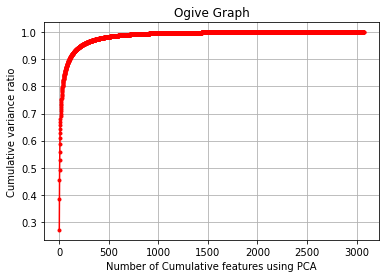

In [ ]:
#function for calculating the cumulative sum of every next element with all the previous one
def Cumulative_sum(lists):   
    cum_list = []   
    length = len(lists)   
    cum_list = [sum(lists[0:x:1]) for x in range(0, length+1)]   
    return cum_list[1:]



#taking all the variance value for each feature
lists = IPCA.explained_variance_ratio_

#print(Cumulative_sum(lists))

#generating the values for the numbering of the features
values  = np.arange(1,3073, 1)


# plotting  the ogive graph
plt.plot(values, Cumulative_sum(lists), color='red', marker='.', linestyle='-')

# formatting
plt.title('Ogive Graph')
plt.xlabel('Number of Cumulative features using PCA')
plt.ylabel('Cumulative variance ratio')
plt.grid()
plt.show()

In [ ]:
cum = Cumulative_sum(lists)
print(cum[1000])

0.9964723869452428


# 2) Classfication Exploration

## 2.a) MLP Standard Training and Evaluation (incl. GridSearchCV)

### MLP Hyperparameters Optimization 

In [ ]:
#modules for cross-validation and tuning the hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold   
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import time
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
model = MLPClassifier()
space = dict()
space = {
       'hidden_layer_sizes': [(500),(500,500),(500,1000,500)],
       'activation': ['tanh', 'logistic', 'relu'],
       'solver': ['sgd', 'adam', 'lbfgs'],
       'max_iter': [200]
        }


classifier = GridSearchCV(model,space, cv=3, scoring='accuracy', n_jobs=-1,verbose=True)

start = time.perf_counter()

classifier.fit(X_transformed[:, 0:1000], y)

finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier.best_score_) 
print('Best Hyperparameters: %s' % classifier.best_params_)

The time it takes to find the best hyperparametes:  366.0265
Best Score: 0.42313333333333336
Best Hyperparameters: {'activation': 'relu', 'hidden_layer_sizes': (500, 1000, 500), 'max_iter': 200, 'solver': 'adam'}


## Training of MLP with best Hyperparamters

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_transformed[:,0:1500], y, stratify=y, test_size=0.20)

# model initialization
mlp = MLPClassifier(verbose=True, activation='relu', hidden_layer_sizes=(500,1000,500), solver='adam', max_iter=200) 


mlp.fit(X_train, y_train) 

Iteration 1, loss = 2.70715521
Iteration 2, loss = 2.04257359
Iteration 3, loss = 1.51674339
Iteration 4, loss = 1.00058586
Iteration 5, loss = 0.57472739
Iteration 6, loss = 0.30752693
Iteration 7, loss = 0.14526324
Iteration 8, loss = 0.10269891
Iteration 9, loss = 0.12510980
Iteration 10, loss = 0.11736471
Iteration 11, loss = 0.11183026
Iteration 12, loss = 0.11896575
Iteration 13, loss = 0.11108676
Iteration 14, loss = 0.09885838
Iteration 15, loss = 0.07695351
Iteration 16, loss = 0.06670959
Iteration 17, loss = 0.05711360
Iteration 18, loss = 0.09205513
Iteration 19, loss = 0.09504685
Iteration 20, loss = 0.06230673
Iteration 21, loss = 0.04786116
Iteration 22, loss = 0.05526570
Iteration 23, loss = 0.04567912
Iteration 24, loss = 0.03631334
Iteration 25, loss = 0.08599827
Iteration 26, loss = 0.10201557
Iteration 27, loss = 0.06431628
Iteration 28, loss = 0.04658452
Iteration 29, loss = 0.05522531
Iteration 30, loss = 0.05730770
Iteration 31, loss = 0.04595051
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(500, 1000, 500), verbose=True)

# 4.2 MLP Evaluation

In [ ]:
ytrue = np.argmax(y_train, axis=1)
ypreda = mlp.predict_proba(X_train[:,0:1500])
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       1.00      1.00      1.00      2418
           2       1.00      0.99      0.99      2406
           3       1.00      0.98      0.99      2406
           4       0.98      1.00      0.99      2399
           5       0.98      1.00      0.99      2363
           6       1.00      1.00      1.00      2413
           7       1.00      0.99      1.00      2434
           8       1.00      0.99      1.00      2379
           9       1.00      1.00      1.00      2396

    accuracy                           0.99     24000
   macro avg       0.99      0.99      0.99     24000
weighted avg       0.99      0.99      0.99     24000

[[2383    1    0    0    0    2    0    0    0    0]
 [   0 2415    0    0    0    2    0    0    0    1]
 [   1    0 2375    0   18   11    0    1    0    0]
 [   0    0    2 2365    8   24    4    2    0    1]
 [   0    0    1    0 2390   

In [ ]:
ytrue = np.argmax(y_test, axis=1)
ypreda = mlp.predict_proba(X_test[:, 0:1500])
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       597
           1       0.56      0.51      0.53       605
           2       0.40      0.35      0.37       601
           3       0.35      0.25      0.29       602
           4       0.39      0.47      0.43       600
           5       0.32      0.52      0.40       591
           6       0.51      0.47      0.49       603
           7       0.56      0.48      0.52       608
           8       0.62      0.57      0.59       594
           9       0.51      0.50      0.50       599

    accuracy                           0.47      6000
   macro avg       0.48      0.47      0.47      6000
weighted avg       0.48      0.47      0.47      6000

[[351  25  31  17  30  31  10  20  55  27]
 [ 31 307  10  23  14  31  15  25  42 107]
 [ 39  10 212  35  96 100  44  36  16  13]
 [ 16  11  47 148  58 181  80  21  19  21]
 [ 24  13  78  28 282  67  34  47  10  17]
 [ 11   5  43  65  60 306 

### Evaluate the performace of MLP using 10 fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(mlp, X_transformed[:, 0:1500], y, cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f"%(scores.mean(), scores.std()))

Iteration 1, loss = 2.64410626
Iteration 2, loss = 1.99814030
Iteration 3, loss = 1.48288767
Iteration 4, loss = 0.98684882
Iteration 5, loss = 0.56129144
Iteration 6, loss = 0.29760874
Iteration 7, loss = 0.17709462
Iteration 8, loss = 0.12785014
Iteration 9, loss = 0.12614771
Iteration 10, loss = 0.11993487
Iteration 11, loss = 0.14815520
Iteration 12, loss = 0.12026622
Iteration 13, loss = 0.07946136
Iteration 14, loss = 0.07864444
Iteration 15, loss = 0.10542236
Iteration 16, loss = 0.08653667
Iteration 17, loss = 0.07446142
Iteration 18, loss = 0.08117718
Iteration 19, loss = 0.08833448
Iteration 20, loss = 0.04960588
Iteration 21, loss = 0.05739940
Iteration 22, loss = 0.06801919
Iteration 23, loss = 0.07902067
Iteration 24, loss = 0.07420994
Iteration 25, loss = 0.06421741
Iteration 26, loss = 0.07797335
Iteration 27, loss = 0.06630719
Iteration 28, loss = 0.06323834
Iteration 29, loss = 0.06649747
Iteration 30, loss = 0.04764925
Iteration 31, loss = 0.06495564
Iteration 32, los

Iteration 1, loss = 2.67078579
Iteration 2, loss = 2.00922187
Iteration 3, loss = 1.50961391
Iteration 4, loss = 1.01312521
Iteration 5, loss = 0.57298775
Iteration 6, loss = 0.30928016
Iteration 7, loss = 0.16539944
Iteration 8, loss = 0.13616768
Iteration 9, loss = 0.13771781
Iteration 10, loss = 0.14226082
Iteration 11, loss = 0.14509907
Iteration 12, loss = 0.08801917
Iteration 13, loss = 0.07835458
Iteration 14, loss = 0.06710934
Iteration 15, loss = 0.08930972
Iteration 16, loss = 0.09474640
Iteration 17, loss = 0.10718761
Iteration 18, loss = 0.10637629
Iteration 19, loss = 0.06445191
Iteration 20, loss = 0.03499927
Iteration 21, loss = 0.04605350
Iteration 22, loss = 0.09966828
Iteration 23, loss = 0.08025818
Iteration 24, loss = 0.10393432
Iteration 25, loss = 0.06991549
Iteration 26, loss = 0.03812814
Iteration 27, loss = 0.04570799
Iteration 28, loss = 0.06392394
Iteration 29, loss = 0.05856321
Iteration 30, loss = 0.05829255
Iteration 31, loss = 0.08242253
Training loss did

## MLP Using EA (sklearn-deap) for Hyper Parameter Optimisation

In [ ]:
!pip install sklearn-deap

### Variant 1: 
population_size=15

gene_mutation_prob=0.10

gene_crossover_prob=0.5

tournament_size= 4

generations_number=10

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold   
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from evolutionary_search import EvolutionaryAlgorithmSearchCV
import time

model = MLPClassifier()
space = dict()
space = {
       'hidden_layer_sizes': [(500),(500,500),(500,1000,500)],
       'activation': ['tanh', 'logistic', 'relu'],
       'solver': ['sgd', 'adam', 'lbfgs'],
       'max_iter': [200]
        }

classifier_evolutionary = EvolutionaryAlgorithmSearchCV(model,space, cv=3, scoring='accuracy',verbose=True,
                                          population_size=15, gene_mutation_prob=0.10, gene_crossover_prob=0.5,
                                          tournament_size= 4, generations_number=10)

start = time.perf_counter()

classifier_evolutionary.fit(X_transformed[:, 0:1000], y)
 
finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier_evolutionary.best_score_) 
print('Best Hyperparameters: %s' % classifier_evolutionary.best_params_)

Types [1, 1, 1, 1] and maxint [2, 2, 2, 0] detected
--- Evolve in 27 possible combinations ---
gen	nevals	avg    	min     	max     	std      
0  	15    	0.41032	0.373767	0.473667	0.0373013
1  	5     	0.458196	0.417567	0.473667	0.0207388
2  	8     	0.468989	0.4622  	0.473667	0.00454402
3  	11    	0.470809	0.4622  	0.475333	0.00408924
4  	9     	0.472582	0.4524  	0.475333	0.00543424
5  	10    	0.475   	0.473667	0.475333	0.000666667
6  	7     	0.468956	0.388067	0.475333	0.0217193  
7  	9     	0.475333	0.475333	0.475333	0          
8  	10    	0.474682	0.467233	0.475333	0.00203353 
9  	10    	0.475333	0.475333	0.475333	0          
10 	9     	0.469516	0.388067	0.475333	0.0217681  
Best individual is: {'hidden_layer_sizes': (500, 500), 'activation': 'relu', 'solver': 'lbfgs', 'max_iter': 200}
with fitness: 0.47533333333333333
The time it takes to find the best hyperparametes:  591.6453333333334
Best Score: 0.47533333333333333
Best Hyperparameters: {'hidden_layer_sizes': (500, 500), 'activatio

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_transformed[:,0:1500], y, stratify=y, test_size=0.20)

# model initialization
mlp2 = MLPClassifier(verbose=True, activation='relu', hidden_layer_sizes=(500,500), solver='lbfgs', max_iter=200) 


mlp2.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(500, 500), solver='lbfgs', verbose=True)

In [ ]:
ytrue = np.argmax(y_train, axis=1)
ypreda = mlp2.predict_proba(X_train[:,0:1500])
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2386
           1       1.00      1.00      1.00      2419
           2       1.00      1.00      1.00      2406
           3       1.00      1.00      1.00      2406
           4       1.00      1.00      1.00      2399
           5       1.00      1.00      1.00      2363
           6       1.00      1.00      1.00      2413
           7       1.00      1.00      1.00      2434
           8       1.00      1.00      1.00      2378
           9       1.00      1.00      1.00      2396

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000

[[2386    0    0    0    0    0    0    0    0    0]
 [   0 2419    0    0    0    0    0    0    0    0]
 [   0    0 2406    0    0    0    0    0    0    0]
 [   0    0    0 2406    0    0    0    0    0    0]
 [   0    0    0    0 2399   

In [ ]:
ytrue = np.argmax(y_test, axis=1)
ypreda = mlp2.predict_proba(X_test[:, 0:1500])
ypred = np.argmax(ypreda, axis=1)
report = classification_report(ytrue, ypred)
print(report)

mat = confusion_matrix(ytrue,ypred)
print(mat)

              precision    recall  f1-score   support

           0       0.53      0.53      0.53       597
           1       0.59      0.56      0.57       604
           2       0.36      0.37      0.37       601
           3       0.31      0.31      0.31       602
           4       0.40      0.42      0.41       600
           5       0.40      0.38      0.39       591
           6       0.52      0.50      0.51       603
           7       0.56      0.55      0.56       608
           8       0.58      0.64      0.61       595
           9       0.54      0.52      0.53       599

    accuracy                           0.48      6000
   macro avg       0.48      0.48      0.48      6000
weighted avg       0.48      0.48      0.48      6000

[[319  27  36  22  23  16  18  17  87  32]
 [ 35 338   8  15  13   9  15  24  52  95]
 [ 49  15 225  55  91  57  38  38  20  13]
 [ 23  12  55 187  48 127  65  44  15  26]
 [ 25  12  99  44 253  32  51  56  17  11]
 [ 18  11  60 126  46 225 

### Variant 2: 
population_size=1000

gene_mutation_prob=0.10

gene_crossover_prob=0.5

tournament_size= 4

generations_number=10

In [ ]:
#modules for cross-validation and tuning the hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold   
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from evolutionary_search import EvolutionaryAlgorithmSearchCV
import time

model = MLPClassifier()
space = dict()
space = {
       'hidden_layer_sizes': [(500),(500,500),(500,1000,500)],
       'activation': ['tanh', 'logistic', 'relu'],
       'solver': ['sgd', 'adam', 'lbfgs'],
       'max_iter': [200]
        }

classifier_evolutionary = EvolutionaryAlgorithmSearchCV(model,space, cv=3, scoring='accuracy',verbose=True,
                                          population_size=1000, gene_mutation_prob=0.10, gene_crossover_prob=0.5,
                                          tournament_size= 4, generations_number=10)

start = time.perf_counter()

classifier_evolutionary.fit(X_transformed[:, 0:1000], y)

finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier_evolutionary.best_score_) 
print('Best Hyperparameters: %s' % classifier_evolutionary.best_params_)

Types [1, 1, 1, 1] and maxint [2, 2, 2, 0] detected
--- Evolve in 27 possible combinations ---


C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_

C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\grid-6\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of 

gen	nevals	avg     	min   	max     	std      
0  	1000  	0.277015	0.0387	0.414933	0.0670663
1  	588   	0.332302	0.0387	0.414933	0.0477075
2  	587   	0.373333	0.0387	0.414933	0.0383951
3  	611   	0.403936	0.267533	0.414933	0.0255964
4  	623   	0.411462	0.217867	0.414933	0.0194016
5  	590   	0.411789	0.253667	0.414933	0.0180757
6  	589   	0.411496	0.267533	0.414933	0.0189204
7  	582   	0.411966	0.267533	0.414933	0.0179341
8  	596   	0.411636	0.267533	0.414933	0.0182485
9  	546   	0.410784	0.267533	0.414933	0.0202525
10 	609   	0.410997	0.0387  	0.414933	0.0226876
Best individual is: {'hidden_layer_sizes': (500, 1000, 500), 'activation': 'relu', 'solver': 'adam', 'max_iter': 200}
with fitness: 0.4149333333333333
The time it takes to find the best hyperparametes:  449.3456666666667
Best Score: 0.4149333333333333
Best Hyperparameters: {'hidden_layer_sizes': (500, 1000, 500), 'activation': 'relu', 'solver': 'adam', 'max_iter': 200}


### Variant 3: 
population_size=1000

gene_mutation_prob=0.15

gene_crossover_prob=0.6

tournament_size= 4

generations_number= 5

In [ ]:
#modules for cross-validation and tuning the hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold   
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from evolutionary_search import EvolutionaryAlgorithmSearchCV
import time

model = MLPClassifier()
space = dict()
space = {
       'hidden_layer_sizes': [(500),(500,500),(500,1000,500)],
       'activation': ['tanh', 'logistic', 'relu'],
       'solver': ['sgd', 'adam', 'lbfgs'],
       'max_iter': [300]
        }

classifier_evolutionary = EvolutionaryAlgorithmSearchCV(model,space, cv=3, scoring='accuracy',verbose=True,
                                          population_size=1000, gene_mutation_prob=0.15, gene_crossover_prob=0.6,
                                          tournament_size= 4, generations_number=5)

start = time.perf_counter()

classifier_evolutionary.fit(X_transformed[:, 0:1000], y)

finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier_evolutionary.best_score_) 
print('Best Hyperparameters: %s' % classifier_evolutionary.best_params_)

Types [1, 1, 1, 1] and maxint [2, 2, 2, 0] detected
--- Evolve in 27 possible combinations ---
gen	nevals	avg     	min   	max     	std      
0  	1000  	0.281597	0.0857	0.410633	0.0647246
1  	608   	0.335321	0.0857	0.410633	0.0499455
2  	585   	0.37346 	0.0857	0.410633	0.0346783
3  	611   	0.400136	0.0857	0.410633	0.0257464
4  	623   	0.405232	0.234067	0.410633	0.0221699
5  	629   	0.405766	0.0857  	0.410633	0.0243168
Best individual is: {'hidden_layer_sizes': (500, 1000, 500), 'activation': 'relu', 'solver': 'adam', 'max_iter': 300}
with fitness: 0.41063333333333335
The time it takes to find the best hyperparametes:  522.8203333333333
Best Score: 0.41063333333333335
Best Hyperparameters: {'hidden_layer_sizes': (500, 1000, 500), 'activation': 'relu', 'solver': 'adam', 'max_iter': 300}


### Variant 4: 
population_size=2000

gene_mutation_prob=0.15

gene_crossover_prob=0.6

tournament_size= 4

generations_number= 4

In [ ]:
#modules for cross-validation and tuning the hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold   
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from evolutionary_search import EvolutionaryAlgorithmSearchCV
import time

model = MLPClassifier()
space = dict()
space = {
       'hidden_layer_sizes': [(500),(500,500),(500,1000,500)],
       'activation': ['tanh', 'logistic', 'relu'],
       'solver': ['sgd', 'adam', 'lbfgs'],
       'max_iter': [200]
        }

classifier_evolutionary = EvolutionaryAlgorithmSearchCV(model,space, cv=3, scoring='accuracy',verbose=True,
                                          population_size=2000, gene_mutation_prob=0.15, gene_crossover_prob=0.6,
                                          tournament_size= 4, generations_number=4)

start = time.perf_counter()

classifier_evolutionary.fit(X_transformed[:, 0:1000], y)

finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier_evolutionary.best_score_) 
print('Best Hyperparameters: %s' % classifier_evolutionary.best_params_)

Types [1, 1, 1, 1] and maxint [2, 2, 2, 0] detected
--- Evolve in 27 possible combinations ---
gen	nevals	avg     	min      	max     	std      
0  	2000  	0.275783	0.0404667	0.420167	0.0705501
1  	1191  	0.337225	0.0404667	0.420167	0.0532696
2  	1206  	0.379501	0.0404667	0.420167	0.0402433
3  	1222  	0.407417	0.0404667	0.420167	0.031622 
4  	1162  	0.413808	0.0404667	0.420167	0.0282012
Best individual is: {'hidden_layer_sizes': (500, 1000, 500), 'activation': 'relu', 'solver': 'adam', 'max_iter': 200}
with fitness: 0.4201666666666667
The time it takes to find the best hyperparametes:  435.9043333333333
Best Score: 0.4201666666666667
Best Hyperparameters: {'hidden_layer_sizes': (500, 1000, 500), 'activation': 'relu', 'solver': 'adam', 'max_iter': 200}


##  SVM Standard Training and Evaluation (incl. GridSearchCV)

In [ ]:
#modules for cross-validation and tuning the hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

#y = np.where(y==1)[1]

model = SVC(verbose=True, max_iter=1000, cache_size=2000)
space = dict()
space = {
       'C': [1,5],
       'kernel': ['linear', 'poly', 'rbf'],
       'max_iter': [5000]
        }

start = time.perf_counter()
classifier = GridSearchCV(model,space, cv=3, scoring='accuracy', n_jobs=-1,verbose=True)
classifier.fit(X_transformed[0:10000, 0:800], y[0:10000])

finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier.best_score_)
print('Best Hyperparameters: %s' % classifier.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[LibSVM]The time it takes to find the best hyperparametes:  15.225166666666667
Best Score: 0.47320016944705867
Best Hyperparameters: {'C': 5, 'kernel': 'rbf', 'max_iter': 5000}


## SVM Using EA (sklearn-deap) for Hyper Parameter Optimisation 

### Variant 1:

parameter space = {

       'C': [1,5,10],
       'kernel': ['linear', 'poly', 'rbf'],
       'max_iter': [5000],
       'gamma': ['auto', 'scale']
    }

In [ ]:
#modules for cross-validation and tuning the hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

#y = np.where(y==1)[1]

model = SVC(verbose=True, max_iter=1000, cache_size=2000)
space = dict()
space = {
       'C': [1,5],
       'kernel': ['linear', 'poly', 'rbf'],
       'max_iter': [5000]
        }

start = time.perf_counter()
classifier_evolutionary = EvolutionaryAlgorithmSearchCV(model,space, cv=3, scoring='accuracy',verbose=True,
                                          population_size=1000, gene_mutation_prob=0.15, gene_crossover_prob=0.6,
                                          tournament_size= 4, generations_number=5)

classifier_evolutionary.fit(X_transformed[0:10000, 0:800], y[0:10000])

finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier_evolutionary.best_score_)
print('Best Hyperparameters: %s' % classifier_evolutionary.best_params_)

Types [1, 1, 1] and maxint [1, 2, 0] detected
--- Evolve in 6 possible combinations ---
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]gen	nevals	avg     	min   	max   	std      
0  	1000  	0.377253	0.2932	0.4732	0.0698492
1  	603   	0.446733	0.2932	0.4732	0.0432038
2  	591   	0.469719	0.2932	0.4732	0.0199419
3  	629   	0.470366	0.2932	0.4732	0.0198306
4  	588   	0.471074	0.2932	0.4732	0.0165575
5  	598   	0.470902	0.2932	0.4732	0.0178571
Best individual is: {'C': 5, 'kernel': 'rbf', 'max_iter': 5000}
with fitness: 0.4732
[LibSVM]The time it takes to find the best hyperparametes:  12.3385
Best Score: 0.4732
Best Hyperparameters: {'C': 5, 'kernel': 'rbf', 'max_iter': 5000}


### Variant 2: 
parameter space = {

           'C': [1,5,10],
           'kernel': ['linear', 'poly', 'rbf'],
           'max_iter': [3000, 5000],
           'gamma': ['auto', 'scale']
        }

In [ ]:
#modules for cross-validation and tuning the hyperparameters
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

#y = np.where(y==1)[1]

model = SVC(verbose=True, max_iter=1000, cache_size=2000)
space = dict()
space = {
       'C': [1,5,10],
       'kernel': ['linear', 'poly', 'rbf'],
       'max_iter': [3000, 5000],
       'gamma': ['auto', 'scale']
        }

start = time.perf_counter()
classifier_evolutionary = EvolutionaryAlgorithmSearchCV(model,space, cv=3, scoring='accuracy',verbose=True,
                                          population_size=1000, gene_mutation_prob=0.15, gene_crossover_prob=0.6,
                                          tournament_size= 4, generations_number=5)

classifier_evolutionary.fit(X_transformed[0:10000, 0:800], y[0:10000])

finish = time.perf_counter()

print("The time it takes to find the best hyperparametes: ", round(finish -start, 2)/60)

# summarize result
print('Best Score: %s' % classifier_evolutionary.best_score_)
print('Best Hyperparameters: %s' % classifier_evolutionary.best_params_)

Types [1, 1, 1, 1] and maxint [2, 2, 1, 1] detected
--- Evolve in 36 possible combinations ---
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]gen	nevals	avg     	min   	max   	std    

# 4.2 SVM Evaluation

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_transformed[0:10000,0:800], y[0:10000], stratify=y[0:10000], test_size=0.20)
# model initialization

svm3 = SVC(verbose=True, max_iter=5000, cache_size=2000, kernel='rbf', C=5) 


svm3.fit(X_train, y_train) 

[LibSVM]

SVC(C=5, cache_size=2000, max_iter=5000, verbose=True)

In [ ]:
#evaluation with train data
ypredict = svm3.predict(X_train)
report = classification_report(y_train, ypredict)
print(report)

mat = confusion_matrix(y_train, ypredict)
print(mat)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       804
           1       1.00      0.99      1.00       779
           2       0.94      0.95      0.94       825
           3       0.99      0.95      0.97       813
           4       0.93      0.96      0.95       799
           5       0.99      0.96      0.98       750
           6       0.96      0.98      0.97       824
           7       1.00      0.98      0.99       801
           8       0.97      0.99      0.98       820
           9       1.00      0.99      1.00       785

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000

[[787   0   4   0   2   0   1   1   9   0]
 [  0 775   1   0   0   0   0   0   2   1]
 [ 11   0 785   1  17   0   7   0   4   0]
 [  1   0  12 774  12   3  10   0   1   0]
 [  5   0  17   0 765   1   9   0   2   0]
 [  1   0   9   4   6 722 

In [ ]:
#evaluation with test data
ypredict = svm3.predict(X_test)
report = classification_report(y_test, ypredict)
print(report)

mat = confusion_matrix(y_test, ypredict)
print(mat)

              precision    recall  f1-score   support

           0       0.48      0.55      0.51       201
           1       0.55      0.60      0.57       195
           2       0.34      0.31      0.32       207
           3       0.30      0.29      0.30       203
           4       0.42      0.45      0.43       200
           5       0.36      0.33      0.34       187
           6       0.50      0.52      0.51       206
           7       0.57      0.45      0.50       200
           8       0.56      0.61      0.58       205
           9       0.53      0.52      0.52       196

    accuracy                           0.46      2000
   macro avg       0.46      0.46      0.46      2000
weighted avg       0.46      0.46      0.46      2000

[[110  12  13   7   5   4   3   7  30  10]
 [ 10 117   0   3   6   7   4   5  16  27]
 [ 23   9  64  22  32  17  15   6  12   7]
 [  8   7  20  59  12  37  31  10   6  13]
 [ 14   5  27  15  89  10  20   9   8   3]
 [  6   5  12  43  15  62 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_transformed[0:10000,0:800], y[0:10000], stratify=y[0:10000], test_size=0.20)
# model initialization

svm2 = SVC(verbose=True, max_iter=3000, cache_size=2000, kernel='rbf', C=5, gamma='scale') 


svm2.fit(X_train, y_train) 

[LibSVM]

SVC(C=5, cache_size=2000, max_iter=3000, verbose=True)

In [ ]:
#evaluation with train data
ypredict = svm2.predict(X_train)
report = classification_report(y_train, ypredict)
print(report)

mat = confusion_matrix(y_train, ypredict)
print(mat)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       804
           1       1.00      0.99      1.00       779
           2       0.92      0.94      0.93       825
           3       0.99      0.95      0.97       813
           4       0.94      0.96      0.95       799
           5       0.99      0.96      0.98       750
           6       0.95      0.98      0.96       824
           7       1.00      0.98      0.99       801
           8       0.98      0.99      0.98       820
           9       1.00      0.99      1.00       785

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000

[[786   0   6   0   3   0   1   0   8   0]
 [  0 775   1   0   0   0   0   0   2   1]
 [ 12   0 774   2  21   1  12   1   2   0]
 [  1   0  14 773   8   1  14   1   1   0]
 [  3   0  19   0 765   1   9   1   1   0]
 [  2   0  15   1   6 719 

In [ ]:
#evaluation with test data
ypredict = svm2.predict(X_test)
report = classification_report(y_test, ypredict)
print(report)

mat = confusion_matrix(y_test, ypredict)
print(mat)

              precision    recall  f1-score   support

           0       0.50      0.53      0.52       201
           1       0.52      0.56      0.54       195
           2       0.36      0.43      0.39       207
           3       0.34      0.33      0.33       203
           4       0.43      0.43      0.43       200
           5       0.41      0.34      0.37       187
           6       0.55      0.53      0.54       206
           7       0.63      0.54      0.58       200
           8       0.59      0.63      0.61       205
           9       0.50      0.48      0.49       196

    accuracy                           0.48      2000
   macro avg       0.48      0.48      0.48      2000
weighted avg       0.48      0.48      0.48      2000

[[106   8  16   8   4   0   4   6  36  13]
 [ 10 110   6   3   5   4   2   6  15  34]
 [ 18   6  88  15  29  13  15  13   7   3]
 [  8   6  24  66  17  41  20   7   4  10]
 [ 12   2  44  13  86   8  15  13   2   5]
 [  2   7  21  45  12  64 

### Evaluate the performace of SVM using 10 fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm2, X_transformed[0:10000, 0:800], y[0:10000], cv=10)
print("%0.2f accuracy with a standard deviation of %0.2f"%(scores.mean(), scores.std()))

0.49 accuracy with a standard deviation of 0.01


# 3) Implement your own Evolutionary Algorithm for Hyper Parameter Optimisation

Iteration 1, loss = 1.96911488
Iteration 2, loss = 1.17886293
Iteration 3, loss = 0.76191785
Iteration 4, loss = 0.40080042
Iteration 5, loss = 0.19400342
Iteration 6, loss = 0.09021890
Iteration 7, loss = 0.04103690
Iteration 8, loss = 0.02057644
Iteration 9, loss = 0.01295762
Iteration 10, loss = 0.00910682
Iteration 11, loss = 0.00699347
Iteration 12, loss = 0.00564075
Iteration 13, loss = 0.00467738
Iteration 14, loss = 0.00397346
Iteration 15, loss = 0.00343439
Iteration 16, loss = 0.00301575
Iteration 17, loss = 0.00268481
Iteration 18, loss = 0.00240219
Iteration 19, loss = 0.00217808
Iteration 20, loss = 0.00198798
Iteration 21, loss = 0.00182460
Iteration 22, loss = 0.00168740
Iteration 23, loss = 0.00157154
Iteration 24, loss = 0.00147153
Iteration 25, loss = 0.00138123
Iteration 26, loss = 0.00130577
Iteration 27, loss = 0.00123689
Iteration 28, loss = 0.00117627
Iteration 29, loss = 0.00112329
Iteration 30, loss = 0.00107451
Iteration 31, loss = 0.00103135
Iteration 32, los

Iteration 151, loss = 1.45378697
Iteration 152, loss = 1.45225975
Iteration 153, loss = 1.45094123
Iteration 154, loss = 1.44839027
Iteration 155, loss = 1.44628520
Iteration 156, loss = 1.44487838
Iteration 157, loss = 1.44284466
Iteration 158, loss = 1.44073200
Iteration 159, loss = 1.43929478
Iteration 160, loss = 1.43682466
Iteration 161, loss = 1.43502659
Iteration 162, loss = 1.43322397
Iteration 163, loss = 1.43119062
Iteration 164, loss = 1.42920277
Iteration 165, loss = 1.42766348
Iteration 166, loss = 1.42548065
Iteration 167, loss = 1.42422755
Iteration 168, loss = 1.42231180
Iteration 169, loss = 1.42068112
Iteration 170, loss = 1.41894936
Iteration 171, loss = 1.41639958
Iteration 172, loss = 1.41459661
Iteration 173, loss = 1.41249706
Iteration 174, loss = 1.41080104
Iteration 175, loss = 1.40920250
Iteration 176, loss = 1.40724716
Iteration 177, loss = 1.40510161
Iteration 178, loss = 1.40313274
Iteration 179, loss = 1.40112581
Iteration 180, loss = 1.39927656
Iteration 

accuracy: 0.327 solver: lbfgs hidden_layers: (500, 1000, 500) activation_func: logistic
Iteration 1, loss = 1.97387043
Iteration 2, loss = 1.61401641
Iteration 3, loss = 1.47663717
Iteration 4, loss = 1.36968329
Iteration 5, loss = 1.28076106
Iteration 6, loss = 1.19843368
Iteration 7, loss = 1.12440113
Iteration 8, loss = 1.04864187
Iteration 9, loss = 0.97953200
Iteration 10, loss = 0.90690253
Iteration 11, loss = 0.84022392
Iteration 12, loss = 0.77141367
Iteration 13, loss = 0.70539848
Iteration 14, loss = 0.64270434
Iteration 15, loss = 0.58157192
Iteration 16, loss = 0.52183227
Iteration 17, loss = 0.46937468
Iteration 18, loss = 0.41580952
Iteration 19, loss = 0.36902369
Iteration 20, loss = 0.32594822
Iteration 21, loss = 0.28861682
Iteration 22, loss = 0.25299220
Iteration 23, loss = 0.22407495
Iteration 24, loss = 0.19570395
Iteration 25, loss = 0.17342621
Iteration 26, loss = 0.15293350
Iteration 27, loss = 0.13551334
Iteration 28, loss = 0.12048576
Iteration 29, loss = 0.10

Iteration 80, loss = 2.24290814
Iteration 81, loss = 2.23995585
Iteration 82, loss = 2.23615608
Iteration 83, loss = 2.23290400
Iteration 84, loss = 2.22988025
Iteration 85, loss = 2.22690873
Iteration 86, loss = 2.22234703
Iteration 87, loss = 2.21964602
Iteration 88, loss = 2.21628451
Iteration 89, loss = 2.21117621
Iteration 90, loss = 2.20807121
Iteration 91, loss = 2.20378256
Iteration 92, loss = 2.19909978
Iteration 93, loss = 2.19630318
Iteration 94, loss = 2.19176595
Iteration 95, loss = 2.18726278
Iteration 96, loss = 2.18221798
Iteration 97, loss = 2.17840593
Iteration 98, loss = 2.17415144
Iteration 99, loss = 2.16933081
Iteration 100, loss = 2.16525428
Iteration 101, loss = 2.16128259
Iteration 102, loss = 2.15741244
Iteration 103, loss = 2.15314381
Iteration 104, loss = 2.14921887
Iteration 105, loss = 2.14566773
Iteration 106, loss = 2.14172116
Iteration 107, loss = 2.13769429
Iteration 108, loss = 2.13425285
Iteration 109, loss = 2.13046181
Iteration 110, loss = 2.127044

Iteration 130, loss = 1.78032836
Iteration 131, loss = 1.77881401
Iteration 132, loss = 1.77752399
Iteration 133, loss = 1.77583802
Iteration 134, loss = 1.77430055
Iteration 135, loss = 1.77310559
Iteration 136, loss = 1.77175598
Iteration 137, loss = 1.77074651
Iteration 138, loss = 1.76923496
Iteration 139, loss = 1.76693007
Iteration 140, loss = 1.76602796
Iteration 141, loss = 1.76427503
Iteration 142, loss = 1.76294353
Iteration 143, loss = 1.76148736
Iteration 144, loss = 1.76015261
Iteration 145, loss = 1.75855290
Iteration 146, loss = 1.75748976
Iteration 147, loss = 1.75562110
Iteration 148, loss = 1.75488011
Iteration 149, loss = 1.75313713
Iteration 150, loss = 1.75148401
Iteration 151, loss = 1.75065164
Iteration 152, loss = 1.74907581
Iteration 153, loss = 1.74792070
Iteration 154, loss = 1.74644899
Iteration 155, loss = 1.74483069
Iteration 156, loss = 1.74379513
Iteration 157, loss = 1.74239412
Iteration 158, loss = 1.74130671
Iteration 159, loss = 1.73987823
Iteration 

Iteration 177, loss = 1.71926190
Iteration 178, loss = 1.71767609
Iteration 179, loss = 1.71644170
Iteration 180, loss = 1.71512490
Iteration 181, loss = 1.71424278
Iteration 182, loss = 1.71312782
Iteration 183, loss = 1.71226282
Iteration 184, loss = 1.71080157
Iteration 185, loss = 1.70904695
Iteration 186, loss = 1.70845486
Iteration 187, loss = 1.70674544
Iteration 188, loss = 1.70595028
Iteration 189, loss = 1.70397397
Iteration 190, loss = 1.70334250
Iteration 191, loss = 1.70205582
Iteration 192, loss = 1.70087656
Iteration 193, loss = 1.69983516
Iteration 194, loss = 1.69816149
Iteration 195, loss = 1.69708356
Iteration 196, loss = 1.69645535
Iteration 197, loss = 1.69501947
Iteration 198, loss = 1.69354075
Iteration 199, loss = 1.69275471
Iteration 200, loss = 1.69132849
accuracy: 0.3785 solver: sgd hidden_layers: (500, 500) activation_func: logistic
Iteration 1, loss = 2.17712678
Iteration 2, loss = 1.92298527
Iteration 3, loss = 1.83143219
Iteration 4, loss = 1.77262429
Ite

Iteration 25, loss = 2.09813748
Iteration 26, loss = 2.09026242
Iteration 27, loss = 2.08114207
Iteration 28, loss = 2.07285890
Iteration 29, loss = 2.06570944
Iteration 30, loss = 2.05804647
Iteration 31, loss = 2.05065558
Iteration 32, loss = 2.04447884
Iteration 33, loss = 2.03710780
Iteration 34, loss = 2.03045049
Iteration 35, loss = 2.02371731
Iteration 36, loss = 2.01761748
Iteration 37, loss = 2.01179369
Iteration 38, loss = 2.00617447
Iteration 39, loss = 2.00026085
Iteration 40, loss = 1.99514757
Iteration 41, loss = 1.98957926
Iteration 42, loss = 1.98498832
Iteration 43, loss = 1.97953452
Iteration 44, loss = 1.97563347
Iteration 45, loss = 1.97041406
Iteration 46, loss = 1.96609249
Iteration 47, loss = 1.96149906
Iteration 48, loss = 1.95731000
Iteration 49, loss = 1.95352121
Iteration 50, loss = 1.94931983
Iteration 51, loss = 1.94556543
Iteration 52, loss = 1.94171454
Iteration 53, loss = 1.93791519
Iteration 54, loss = 1.93513644
Iteration 55, loss = 1.93101266
Iteratio

Iteration 76, loss = 1.87551875
Iteration 77, loss = 1.87269501
Iteration 78, loss = 1.87069484
Iteration 79, loss = 1.86843127
Iteration 80, loss = 1.86622975
Iteration 81, loss = 1.86489584
Iteration 82, loss = 1.86275295
Iteration 83, loss = 1.86087985
Iteration 84, loss = 1.85861391
Iteration 85, loss = 1.85644050
Iteration 86, loss = 1.85433212
Iteration 87, loss = 1.85308109
Iteration 88, loss = 1.85056857
Iteration 89, loss = 1.84859209
Iteration 90, loss = 1.84705172
Iteration 91, loss = 1.84539501
Iteration 92, loss = 1.84308874
Iteration 93, loss = 1.84133836
Iteration 94, loss = 1.84034893
Iteration 95, loss = 1.83831380
Iteration 96, loss = 1.83614423
Iteration 97, loss = 1.83433069
Iteration 98, loss = 1.83238950
Iteration 99, loss = 1.83139749
Iteration 100, loss = 1.82918330
Iteration 101, loss = 1.82728638
Iteration 102, loss = 1.82614303
Iteration 103, loss = 1.82475800
Iteration 104, loss = 1.82277805
Iteration 105, loss = 1.82041679
Iteration 106, loss = 1.81905906
I

Iteration 91, loss = 1.56463696
Iteration 92, loss = 1.56296156
Iteration 93, loss = 1.56069049
Iteration 94, loss = 1.55875495
Iteration 95, loss = 1.55755906
Iteration 96, loss = 1.55482568
Iteration 97, loss = 1.55259679
Iteration 98, loss = 1.55096455
Iteration 99, loss = 1.54871403
Iteration 100, loss = 1.54728207
Iteration 101, loss = 1.54458408
Iteration 102, loss = 1.54235739
Iteration 103, loss = 1.54052279
Iteration 104, loss = 1.53836085
Iteration 105, loss = 1.53648387
Iteration 106, loss = 1.53465306
Iteration 107, loss = 1.53326600
Iteration 108, loss = 1.53048405
Iteration 109, loss = 1.52877197
Iteration 110, loss = 1.52670538
Iteration 111, loss = 1.52490069
Iteration 112, loss = 1.52287358
Iteration 113, loss = 1.52080186
Iteration 114, loss = 1.51881582
Iteration 115, loss = 1.51708729
Iteration 116, loss = 1.51503916
Iteration 117, loss = 1.51290900
Iteration 118, loss = 1.51079551
Iteration 119, loss = 1.50906056
Iteration 120, loss = 1.50713226
Iteration 121, loss

Iteration 141, loss = 0.05323087
Iteration 142, loss = 0.05241069
Iteration 143, loss = 0.05151622
Iteration 144, loss = 0.05081088
Iteration 145, loss = 0.04988034
Iteration 146, loss = 0.04893536
Iteration 147, loss = 0.04829000
Iteration 148, loss = 0.04758418
Iteration 149, loss = 0.04684602
Iteration 150, loss = 0.04616265
Iteration 151, loss = 0.04543472
Iteration 152, loss = 0.04467996
Iteration 153, loss = 0.04397354
Iteration 154, loss = 0.04335273
Iteration 155, loss = 0.04276998
Iteration 156, loss = 0.04207473
Iteration 157, loss = 0.04152866
Iteration 158, loss = 0.04085308
Iteration 159, loss = 0.04027423
Iteration 160, loss = 0.03970216
Iteration 161, loss = 0.03917339
Iteration 162, loss = 0.03860634
Iteration 163, loss = 0.03808375
Iteration 164, loss = 0.03760563
Iteration 165, loss = 0.03699906
Iteration 166, loss = 0.03658729
Iteration 167, loss = 0.03602778
Iteration 168, loss = 0.03557996
Iteration 169, loss = 0.03511525
Iteration 170, loss = 0.03467926
Iteration 

Iteration 191, loss = 0.07598238
Iteration 192, loss = 0.07506229
Iteration 193, loss = 0.07447129
Iteration 194, loss = 0.07372575
Iteration 195, loss = 0.07293949
Iteration 196, loss = 0.07242618
Iteration 197, loss = 0.07147158
Iteration 198, loss = 0.07097158
Iteration 199, loss = 0.07011866
Iteration 200, loss = 0.06942769
accuracy: 0.439 solver: sgd hidden_layers: 500 activation_func: relu
Iteration 1, loss = 2.43894716
Iteration 2, loss = 1.91556800
Iteration 3, loss = 1.75787778
Iteration 4, loss = 1.66096830
Iteration 5, loss = 1.58594115
Iteration 6, loss = 1.52581691
Iteration 7, loss = 1.47471702
Iteration 8, loss = 1.43031393
Iteration 9, loss = 1.38926723
Iteration 10, loss = 1.35207068
Iteration 11, loss = 1.31916896
Iteration 12, loss = 1.28866740
Iteration 13, loss = 1.26144664
Iteration 14, loss = 1.23132911
Iteration 15, loss = 1.20463315
Iteration 16, loss = 1.18094315
Iteration 17, loss = 1.15630813
Iteration 18, loss = 1.13433292
Iteration 19, loss = 1.11138432
It

Iteration 40, loss = 0.98782250
Iteration 41, loss = 0.97036378
Iteration 42, loss = 0.95331555
Iteration 43, loss = 0.93529920
Iteration 44, loss = 0.91734192
Iteration 45, loss = 0.89879091
Iteration 46, loss = 0.88212402
Iteration 47, loss = 0.86396320
Iteration 48, loss = 0.84673205
Iteration 49, loss = 0.82862516
Iteration 50, loss = 0.81291436
Iteration 51, loss = 0.79543840
Iteration 52, loss = 0.77969531
Iteration 53, loss = 0.76099626
Iteration 54, loss = 0.74398053
Iteration 55, loss = 0.72888327
Iteration 56, loss = 0.71116773
Iteration 57, loss = 0.69447567
Iteration 58, loss = 0.67792926
Iteration 59, loss = 0.66367496
Iteration 60, loss = 0.64676747
Iteration 61, loss = 0.63144875
Iteration 62, loss = 0.61645521
Iteration 63, loss = 0.60030152
Iteration 64, loss = 0.58538642
Iteration 65, loss = 0.57116278
Iteration 66, loss = 0.55590726
Iteration 67, loss = 0.54183283
Iteration 68, loss = 0.52660807
Iteration 69, loss = 0.51353084
Iteration 70, loss = 0.49988488
Iteratio

Iteration 91, loss = 0.15973823
Iteration 92, loss = 0.15555645
Iteration 93, loss = 0.15122904
Iteration 94, loss = 0.14818614
Iteration 95, loss = 0.14381804
Iteration 96, loss = 0.14021805
Iteration 97, loss = 0.13694545
Iteration 98, loss = 0.13313308
Iteration 99, loss = 0.12972430
Iteration 100, loss = 0.12686935
Iteration 101, loss = 0.12338464
Iteration 102, loss = 0.12054465
Iteration 103, loss = 0.11753583
Iteration 104, loss = 0.11466253
Iteration 105, loss = 0.11175989
Iteration 106, loss = 0.10956501
Iteration 107, loss = 0.10680880
Iteration 108, loss = 0.10415212
Iteration 109, loss = 0.10192855
Iteration 110, loss = 0.09949735
Iteration 111, loss = 0.09768362
Iteration 112, loss = 0.09522292
Iteration 113, loss = 0.09323566
Iteration 114, loss = 0.09129083
Iteration 115, loss = 0.08932263
Iteration 116, loss = 0.08722709
Iteration 117, loss = 0.08530046
Iteration 118, loss = 0.08350053
Iteration 119, loss = 0.08180979
Iteration 120, loss = 0.07998312
Iteration 121, loss

Iteration 38, loss = 1.69953078
Iteration 39, loss = 1.69678605
Iteration 40, loss = 1.69303942
Iteration 41, loss = 1.69005840
Iteration 42, loss = 1.68661189
Iteration 43, loss = 1.68409630
Iteration 44, loss = 1.68065814
Iteration 45, loss = 1.67808466
Iteration 46, loss = 1.67499040
Iteration 47, loss = 1.67197790
Iteration 48, loss = 1.66867937
Iteration 49, loss = 1.66637976
Iteration 50, loss = 1.66356449
Iteration 51, loss = 1.66093969
Iteration 52, loss = 1.65774771
Iteration 53, loss = 1.65527021
Iteration 54, loss = 1.65323746
Iteration 55, loss = 1.65050895
Iteration 56, loss = 1.64804883
Iteration 57, loss = 1.64498831
Iteration 58, loss = 1.64288448
Iteration 59, loss = 1.64015506
Iteration 60, loss = 1.63731327
Iteration 61, loss = 1.63519965
Iteration 62, loss = 1.63253837
Iteration 63, loss = 1.63047930
Iteration 64, loss = 1.62806373
Iteration 65, loss = 1.62567748
Iteration 66, loss = 1.62307632
Iteration 67, loss = 1.62079017
Iteration 68, loss = 1.61909888
Iteratio

Iteration 24, loss = 0.00883137
Iteration 25, loss = 0.00814157
Iteration 26, loss = 0.00752510
Iteration 27, loss = 0.00697378
Iteration 28, loss = 0.00648713
Iteration 29, loss = 0.00605685
Iteration 30, loss = 0.00565933
Iteration 31, loss = 0.00531566
Iteration 32, loss = 0.00499545
Iteration 33, loss = 0.00470776
Iteration 34, loss = 0.00444354
Iteration 35, loss = 0.00420854
Iteration 36, loss = 0.00398287
Iteration 37, loss = 0.00378285
Iteration 38, loss = 0.00360105
Iteration 39, loss = 0.00342763
Iteration 40, loss = 0.00327043
Iteration 41, loss = 0.00312375
Iteration 42, loss = 0.00298805
Iteration 43, loss = 0.00286101
Iteration 44, loss = 0.00274518
Iteration 45, loss = 0.00263454
Iteration 46, loss = 0.00253324
Iteration 47, loss = 0.00244051
Iteration 48, loss = 0.00235114
Iteration 49, loss = 0.00226627
Iteration 50, loss = 0.00218801
Iteration 51, loss = 0.00211349
Iteration 52, loss = 0.00204475
Iteration 53, loss = 0.00197753
Iteration 54, loss = 0.00191603
Iteratio

Iteration 145, loss = 0.13265165
Iteration 146, loss = 0.13118069
Iteration 147, loss = 0.12991804
Iteration 148, loss = 0.12783767
Iteration 149, loss = 0.12604732
Iteration 150, loss = 0.12456220
Iteration 151, loss = 0.12288540
Iteration 152, loss = 0.12162045
Iteration 153, loss = 0.11999269
Iteration 154, loss = 0.11863636
Iteration 155, loss = 0.11691471
Iteration 156, loss = 0.11575971
Iteration 157, loss = 0.11404597
Iteration 158, loss = 0.11288118
Iteration 159, loss = 0.11166594
Iteration 160, loss = 0.11007093
Iteration 161, loss = 0.10909264
Iteration 162, loss = 0.10755420
Iteration 163, loss = 0.10641604
Iteration 164, loss = 0.10536468
Iteration 165, loss = 0.10365733
Iteration 166, loss = 0.10256689
Iteration 167, loss = 0.10153509
Iteration 168, loss = 0.10035279
Iteration 169, loss = 0.09938053
Iteration 170, loss = 0.09826127
Iteration 171, loss = 0.09692190
Iteration 172, loss = 0.09587562
Iteration 173, loss = 0.09460351
Iteration 174, loss = 0.09382057
Iteration 

Iteration 195, loss = 0.07331979
Iteration 196, loss = 0.07254703
Iteration 197, loss = 0.07193601
Iteration 198, loss = 0.07116120
Iteration 199, loss = 0.07068180
Iteration 200, loss = 0.06987706
accuracy: 0.4165 solver: sgd hidden_layers: 500 activation_func: relu
Iteration 1, loss = 2.40798138
Iteration 2, loss = 1.89845081
Iteration 3, loss = 1.74591869
Iteration 4, loss = 1.64767317
Iteration 5, loss = 1.57313580
Iteration 6, loss = 1.51358547
Iteration 7, loss = 1.46200464
Iteration 8, loss = 1.41642348
Iteration 9, loss = 1.37756998
Iteration 10, loss = 1.34279951
Iteration 11, loss = 1.30742020
Iteration 12, loss = 1.27560560
Iteration 13, loss = 1.24627025
Iteration 14, loss = 1.21921242
Iteration 15, loss = 1.19404241
Iteration 16, loss = 1.16754303
Iteration 17, loss = 1.14422508
Iteration 18, loss = 1.12152058
Iteration 19, loss = 1.10089745
Iteration 20, loss = 1.07825202
Iteration 21, loss = 1.05748797
Iteration 22, loss = 1.03732955
Iteration 23, loss = 1.01719888
Itera

Iteration 44, loss = 0.69076694
Iteration 45, loss = 0.67806593
Iteration 46, loss = 0.66546564
Iteration 47, loss = 0.65210705
Iteration 48, loss = 0.64015555
Iteration 49, loss = 0.62876231
Iteration 50, loss = 0.61716114
Iteration 51, loss = 0.60609781
Iteration 52, loss = 0.59526973
Iteration 53, loss = 0.58554102
Iteration 54, loss = 0.57290911
Iteration 55, loss = 0.56198749
Iteration 56, loss = 0.55220358
Iteration 57, loss = 0.54227319
Iteration 58, loss = 0.53125196
Iteration 59, loss = 0.52255191
Iteration 60, loss = 0.51228182
Iteration 61, loss = 0.50377071
Iteration 62, loss = 0.49322416
Iteration 63, loss = 0.48429179
Iteration 64, loss = 0.47627754
Iteration 65, loss = 0.46815466
Iteration 66, loss = 0.45924640
Iteration 67, loss = 0.45055371
Iteration 68, loss = 0.44316960
Iteration 69, loss = 0.43364758
Iteration 70, loss = 0.42574230
Iteration 71, loss = 0.41808323
Iteration 72, loss = 0.41125681
Iteration 73, loss = 0.40451561
Iteration 74, loss = 0.39651152
Iteratio

Iteration 95, loss = 1.56124900
Iteration 96, loss = 1.55905669
Iteration 97, loss = 1.55697101
Iteration 98, loss = 1.55525064
Iteration 99, loss = 1.55329928
Iteration 100, loss = 1.55138423
Iteration 101, loss = 1.54920677
Iteration 102, loss = 1.54681462
Iteration 103, loss = 1.54496223
Iteration 104, loss = 1.54323632
Iteration 105, loss = 1.54159997
Iteration 106, loss = 1.53980100
Iteration 107, loss = 1.53722086
Iteration 108, loss = 1.53624442
Iteration 109, loss = 1.53348660
Iteration 110, loss = 1.53096061
Iteration 111, loss = 1.52910566
Iteration 112, loss = 1.52736923
Iteration 113, loss = 1.52534426
Iteration 114, loss = 1.52311340
Iteration 115, loss = 1.52139527
Iteration 116, loss = 1.51966150
Iteration 117, loss = 1.51753960
Iteration 118, loss = 1.51558317
Iteration 119, loss = 1.51412307
Iteration 120, loss = 1.51171106
Iteration 121, loss = 1.50993499
Iteration 122, loss = 1.50796476
Iteration 123, loss = 1.50582241
Iteration 124, loss = 1.50429177
Iteration 125, 

Iteration 145, loss = 0.13078681
Iteration 146, loss = 0.12930168
Iteration 147, loss = 0.12751028
Iteration 148, loss = 0.12574687
Iteration 149, loss = 0.12417216
Iteration 150, loss = 0.12272781
Iteration 151, loss = 0.12121031
Iteration 152, loss = 0.11972492
Iteration 153, loss = 0.11786684
Iteration 154, loss = 0.11661622
Iteration 155, loss = 0.11503276
Iteration 156, loss = 0.11368452
Iteration 157, loss = 0.11216072
Iteration 158, loss = 0.11096793
Iteration 159, loss = 0.10968946
Iteration 160, loss = 0.10835783
Iteration 161, loss = 0.10735339
Iteration 162, loss = 0.10599875
Iteration 163, loss = 0.10461474
Iteration 164, loss = 0.10338937
Iteration 165, loss = 0.10212086
Iteration 166, loss = 0.10120858
Iteration 167, loss = 0.09988087
Iteration 168, loss = 0.09902821
Iteration 169, loss = 0.09752794
Iteration 170, loss = 0.09649143
Iteration 171, loss = 0.09536816
Iteration 172, loss = 0.09422614
Iteration 173, loss = 0.09324855
Iteration 174, loss = 0.09216014
Iteration 

Iteration 193, loss = 1.36800959
Iteration 194, loss = 1.36629976
Iteration 195, loss = 1.36419952
Iteration 196, loss = 1.36175024
Iteration 197, loss = 1.36044538
Iteration 198, loss = 1.35811391
Iteration 199, loss = 1.35605449
Iteration 200, loss = 1.35458079
accuracy: 0.3975 solver: sgd hidden_layers: 500 activation_func: logistic
2  	10    	0.4161  	0.0309474	0.3255	0.451 
Iteration 1, loss = 2.06323857
Iteration 2, loss = 1.09147711
Iteration 3, loss = 0.72936336
Iteration 4, loss = 0.50130426
Iteration 5, loss = 0.33957998
Iteration 6, loss = 0.22980337
Iteration 7, loss = 0.16119148
Iteration 8, loss = 0.11477023
Iteration 9, loss = 0.08596210
Iteration 10, loss = 0.06594890
Iteration 11, loss = 0.05154764
Iteration 12, loss = 0.04180376
Iteration 13, loss = 0.03434114
Iteration 14, loss = 0.02893511
Iteration 15, loss = 0.02468251
Iteration 16, loss = 0.02124775
Iteration 17, loss = 0.01869257
Iteration 18, loss = 0.01646016
Iteration 19, loss = 0.01464574
Iteration 20, loss 

Iteration 182, loss = 0.03067033
Iteration 183, loss = 0.03022296
Iteration 184, loss = 0.02983087
Iteration 185, loss = 0.02967484
Iteration 186, loss = 0.02927199
Iteration 187, loss = 0.02889521
Iteration 188, loss = 0.02860539
Iteration 189, loss = 0.02827369
Iteration 190, loss = 0.02797965
Iteration 191, loss = 0.02762720
Iteration 192, loss = 0.02735676
Iteration 193, loss = 0.02701463
Iteration 194, loss = 0.02675704
Iteration 195, loss = 0.02644572
Iteration 196, loss = 0.02611650
Iteration 197, loss = 0.02596483
Iteration 198, loss = 0.02566003
Iteration 199, loss = 0.02537516
Iteration 200, loss = 0.02513616
accuracy: 0.436 solver: sgd hidden_layers: (500, 500) activation_func: relu
Iteration 1, loss = 2.47346516
Iteration 2, loss = 1.93222739
Iteration 3, loss = 1.77152636
Iteration 4, loss = 1.67183144
Iteration 5, loss = 1.59217459
Iteration 6, loss = 1.53099274
Iteration 7, loss = 1.47974636
Iteration 8, loss = 1.43347829
Iteration 9, loss = 1.39290367
Iteration 10, loss

Iteration 31, loss = 0.00532199
Iteration 32, loss = 0.00499937
Iteration 33, loss = 0.00471196
Iteration 34, loss = 0.00444925
Iteration 35, loss = 0.00420540
Iteration 36, loss = 0.00399175
Iteration 37, loss = 0.00378978
Iteration 38, loss = 0.00359843
Iteration 39, loss = 0.00342774
Iteration 40, loss = 0.00327227
Iteration 41, loss = 0.00312349
Iteration 42, loss = 0.00298875
Iteration 43, loss = 0.00286299
Iteration 44, loss = 0.00274731
Iteration 45, loss = 0.00263651
Iteration 46, loss = 0.00253380
Iteration 47, loss = 0.00244171
Iteration 48, loss = 0.00234984
Iteration 49, loss = 0.00226767
Iteration 50, loss = 0.00218801
Iteration 51, loss = 0.00211414
Iteration 52, loss = 0.00204573
Iteration 53, loss = 0.00198012
Iteration 54, loss = 0.00191774
Iteration 55, loss = 0.00185952
Iteration 56, loss = 0.00180391
Iteration 57, loss = 0.00175237
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
accuracy: 0.407 solver: adam hidden_layers: 50

Iteration 20, loss = 1.08038457
Iteration 21, loss = 1.05891477
Iteration 22, loss = 1.03927086
Iteration 23, loss = 1.02115729
Iteration 24, loss = 1.00367503
Iteration 25, loss = 0.98336395
Iteration 26, loss = 0.96512707
Iteration 27, loss = 0.94778137
Iteration 28, loss = 0.92955929
Iteration 29, loss = 0.91409934
Iteration 30, loss = 0.89561370
Iteration 31, loss = 0.88104199
Iteration 32, loss = 0.86435284
Iteration 33, loss = 0.84891498
Iteration 34, loss = 0.83359510
Iteration 35, loss = 0.81887540
Iteration 36, loss = 0.80393813
Iteration 37, loss = 0.78939347
Iteration 38, loss = 0.77470856
Iteration 39, loss = 0.76099378
Iteration 40, loss = 0.74738362
Iteration 41, loss = 0.73435894
Iteration 42, loss = 0.72232061
Iteration 43, loss = 0.70803653
Iteration 44, loss = 0.69616021
Iteration 45, loss = 0.68354338
Iteration 46, loss = 0.67237179
Iteration 47, loss = 0.65858821
Iteration 48, loss = 0.64743371
Iteration 49, loss = 0.63486370
Iteration 50, loss = 0.62355660
Iteratio

Iteration 10, loss = 1.35422900
Iteration 11, loss = 1.32031256
Iteration 12, loss = 1.28825457
Iteration 13, loss = 1.25806537
Iteration 14, loss = 1.22879056
Iteration 15, loss = 1.20228907
Iteration 16, loss = 1.17640323
Iteration 17, loss = 1.15412058
Iteration 18, loss = 1.12919368
Iteration 19, loss = 1.10851043
Iteration 20, loss = 1.08522211
Iteration 21, loss = 1.06436114
Iteration 22, loss = 1.04337526
Iteration 23, loss = 1.02508196
Iteration 24, loss = 1.00549379
Iteration 25, loss = 0.98568875
Iteration 26, loss = 0.96873063
Iteration 27, loss = 0.94976477
Iteration 28, loss = 0.93406580
Iteration 29, loss = 0.91655364
Iteration 30, loss = 0.89963170
Iteration 31, loss = 0.88295630
Iteration 32, loss = 0.86655708
Iteration 33, loss = 0.85230062
Iteration 34, loss = 0.83626761
Iteration 35, loss = 0.82067810
Iteration 36, loss = 0.80678722
Iteration 37, loss = 0.79248862
Iteration 38, loss = 0.77793964
Iteration 39, loss = 0.76373454
Iteration 40, loss = 0.75007106
Iteratio

Iteration 61, loss = 0.37209543
Iteration 62, loss = 0.36310302
Iteration 63, loss = 0.35158081
Iteration 64, loss = 0.34305113
Iteration 65, loss = 0.33245504
Iteration 66, loss = 0.32228208
Iteration 67, loss = 0.31393956
Iteration 68, loss = 0.30528318
Iteration 69, loss = 0.29630727
Iteration 70, loss = 0.28830203
Iteration 71, loss = 0.27950483
Iteration 72, loss = 0.27175693
Iteration 73, loss = 0.26429324
Iteration 74, loss = 0.25727312
Iteration 75, loss = 0.24920048
Iteration 76, loss = 0.24209691
Iteration 77, loss = 0.23492578
Iteration 78, loss = 0.22879387
Iteration 79, loss = 0.22243801
Iteration 80, loss = 0.21663222
Iteration 81, loss = 0.21012537
Iteration 82, loss = 0.20357604
Iteration 83, loss = 0.19894017
Iteration 84, loss = 0.19329856
Iteration 85, loss = 0.18773759
Iteration 86, loss = 0.18342956
Iteration 87, loss = 0.17830399
Iteration 88, loss = 0.17328966
Iteration 89, loss = 0.16866765
Iteration 90, loss = 0.16433720
Iteration 91, loss = 0.15954678
Iteratio

Iteration 111, loss = 1.52466948
Iteration 112, loss = 1.52301357
Iteration 113, loss = 1.52083921
Iteration 114, loss = 1.51903865
Iteration 115, loss = 1.51725589
Iteration 116, loss = 1.51515755
Iteration 117, loss = 1.51324048
Iteration 118, loss = 1.51156433
Iteration 119, loss = 1.50925424
Iteration 120, loss = 1.50733771
Iteration 121, loss = 1.50542418
Iteration 122, loss = 1.50357857
Iteration 123, loss = 1.50124008
Iteration 124, loss = 1.49965059
Iteration 125, loss = 1.49796314
Iteration 126, loss = 1.49552241
Iteration 127, loss = 1.49354076
Iteration 128, loss = 1.49150295
Iteration 129, loss = 1.48957944
Iteration 130, loss = 1.48776568
Iteration 131, loss = 1.48553158
Iteration 132, loss = 1.48403594
Iteration 133, loss = 1.48139547
Iteration 134, loss = 1.47961210
Iteration 135, loss = 1.47787635
Iteration 136, loss = 1.47567220
Iteration 137, loss = 1.47421944
Iteration 138, loss = 1.47216856
Iteration 139, loss = 1.47054401
Iteration 140, loss = 1.46865293
Iteration 

Iteration 161, loss = 0.03847615
Iteration 162, loss = 0.03787894
Iteration 163, loss = 0.03738339
Iteration 164, loss = 0.03689007
Iteration 165, loss = 0.03648254
Iteration 166, loss = 0.03590398
Iteration 167, loss = 0.03536504
Iteration 168, loss = 0.03492954
Iteration 169, loss = 0.03455600
Iteration 170, loss = 0.03408142
Iteration 171, loss = 0.03359743
Iteration 172, loss = 0.03316346
Iteration 173, loss = 0.03278431
Iteration 174, loss = 0.03239012
Iteration 175, loss = 0.03201159
Iteration 176, loss = 0.03157647
Iteration 177, loss = 0.03130527
Iteration 178, loss = 0.03087470
Iteration 179, loss = 0.03046324
Iteration 180, loss = 0.03004567
Iteration 181, loss = 0.02972608
Iteration 182, loss = 0.02938792
Iteration 183, loss = 0.02906644
Iteration 184, loss = 0.02867866
Iteration 185, loss = 0.02836075
Iteration 186, loss = 0.02812789
Iteration 187, loss = 0.02778119
Iteration 188, loss = 0.02749146
Iteration 189, loss = 0.02708221
Iteration 190, loss = 0.02680468
Iteration 

Iteration 172, loss = 0.18721021
Iteration 173, loss = 0.18488565
Iteration 174, loss = 0.18299321
Iteration 175, loss = 0.18072229
Iteration 176, loss = 0.17895596
Iteration 177, loss = 0.17738146
Iteration 178, loss = 0.17510583
Iteration 179, loss = 0.17334650
Iteration 180, loss = 0.17151168
Iteration 181, loss = 0.16953875
Iteration 182, loss = 0.16794489
Iteration 183, loss = 0.16593774
Iteration 184, loss = 0.16418219
Iteration 185, loss = 0.16243417
Iteration 186, loss = 0.16085376
Iteration 187, loss = 0.15896518
Iteration 188, loss = 0.15736922
Iteration 189, loss = 0.15581599
Iteration 190, loss = 0.15410361
Iteration 191, loss = 0.15310905
Iteration 192, loss = 0.15097395
Iteration 193, loss = 0.14977712
Iteration 194, loss = 0.14821997
Iteration 195, loss = 0.14641433
Iteration 196, loss = 0.14517794
Iteration 197, loss = 0.14379501
Iteration 198, loss = 0.14225729
Iteration 199, loss = 0.14091504
Iteration 200, loss = 0.13935691
accuracy: 0.384 solver: sgd hidden_layers: 

Iteration 20, loss = 1.06954497
Iteration 21, loss = 1.03991333
Iteration 22, loss = 1.01160489
Iteration 23, loss = 0.98418426
Iteration 24, loss = 0.95684682
Iteration 25, loss = 0.93068171
Iteration 26, loss = 0.90255622
Iteration 27, loss = 0.87607075
Iteration 28, loss = 0.84966532
Iteration 29, loss = 0.82506873
Iteration 30, loss = 0.79793252
Iteration 31, loss = 0.77279956
Iteration 32, loss = 0.74880118
Iteration 33, loss = 0.72457803
Iteration 34, loss = 0.70042381
Iteration 35, loss = 0.67585840
Iteration 36, loss = 0.65311592
Iteration 37, loss = 0.63118407
Iteration 38, loss = 0.60750879
Iteration 39, loss = 0.58636730
Iteration 40, loss = 0.56513441
Iteration 41, loss = 0.54510408
Iteration 42, loss = 0.52350231
Iteration 43, loss = 0.50488672
Iteration 44, loss = 0.48508240
Iteration 45, loss = 0.46559464
Iteration 46, loss = 0.44683695
Iteration 47, loss = 0.42931404
Iteration 48, loss = 0.41295492
Iteration 49, loss = 0.39575098
Iteration 50, loss = 0.37942315
Iteratio

Iteration 69, loss = 0.43923207
Iteration 70, loss = 0.43171502
Iteration 71, loss = 0.42328679
Iteration 72, loss = 0.41567692
Iteration 73, loss = 0.40887065
Iteration 74, loss = 0.40151658
Iteration 75, loss = 0.39368415
Iteration 76, loss = 0.38722590
Iteration 77, loss = 0.38006077
Iteration 78, loss = 0.37427731
Iteration 79, loss = 0.36761743
Iteration 80, loss = 0.35994271
Iteration 81, loss = 0.35370950
Iteration 82, loss = 0.34719789
Iteration 83, loss = 0.34138128
Iteration 84, loss = 0.33543470
Iteration 85, loss = 0.32997215
Iteration 86, loss = 0.32396703
Iteration 87, loss = 0.31921165
Iteration 88, loss = 0.31315616
Iteration 89, loss = 0.30706588
Iteration 90, loss = 0.30306211
Iteration 91, loss = 0.29704146
Iteration 92, loss = 0.29217397
Iteration 93, loss = 0.28712391
Iteration 94, loss = 0.28339033
Iteration 95, loss = 0.27731348
Iteration 96, loss = 0.27263255
Iteration 97, loss = 0.26808550
Iteration 98, loss = 0.26412862
Iteration 99, loss = 0.25971812
Iteratio

Iteration 120, loss = 0.07385613
Iteration 121, loss = 0.07214640
Iteration 122, loss = 0.07085651
Iteration 123, loss = 0.06918403
Iteration 124, loss = 0.06783565
Iteration 125, loss = 0.06672857
Iteration 126, loss = 0.06518982
Iteration 127, loss = 0.06399081
Iteration 128, loss = 0.06286418
Iteration 129, loss = 0.06160951
Iteration 130, loss = 0.06037755
Iteration 131, loss = 0.05930608
Iteration 132, loss = 0.05805154
Iteration 133, loss = 0.05700649
Iteration 134, loss = 0.05613314
Iteration 135, loss = 0.05502766
Iteration 136, loss = 0.05409976
Iteration 137, loss = 0.05317613
Iteration 138, loss = 0.05233210
Iteration 139, loss = 0.05144695
Iteration 140, loss = 0.05061642
Iteration 141, loss = 0.04975909
Iteration 142, loss = 0.04885123
Iteration 143, loss = 0.04799580
Iteration 144, loss = 0.04723987
Iteration 145, loss = 0.04665419
Iteration 146, loss = 0.04579762
Iteration 147, loss = 0.04509767
Iteration 148, loss = 0.04428178
Iteration 149, loss = 0.04367425
Iteration 

Iteration 168, loss = 0.03401369
Iteration 169, loss = 0.03365133
Iteration 170, loss = 0.03318845
Iteration 171, loss = 0.03271872
Iteration 172, loss = 0.03240868
Iteration 173, loss = 0.03189441
Iteration 174, loss = 0.03160164
Iteration 175, loss = 0.03124626
Iteration 176, loss = 0.03077853
Iteration 177, loss = 0.03040265
Iteration 178, loss = 0.03003652
Iteration 179, loss = 0.02972524
Iteration 180, loss = 0.02931572
Iteration 181, loss = 0.02903866
Iteration 182, loss = 0.02873886
Iteration 183, loss = 0.02835558
Iteration 184, loss = 0.02805219
Iteration 185, loss = 0.02767614
Iteration 186, loss = 0.02739514
Iteration 187, loss = 0.02715783
Iteration 188, loss = 0.02685194
Iteration 189, loss = 0.02654584
Iteration 190, loss = 0.02622111
Iteration 191, loss = 0.02596033
Iteration 192, loss = 0.02567839
Iteration 193, loss = 0.02542340
Iteration 194, loss = 0.02511076
Iteration 195, loss = 0.02489590
Iteration 196, loss = 0.02464506
Iteration 197, loss = 0.02437411
Iteration 

Iteration 16, loss = 1.16727658
Iteration 17, loss = 1.13897396
Iteration 18, loss = 1.11175309
Iteration 19, loss = 1.08641293
Iteration 20, loss = 1.06195870
Iteration 21, loss = 1.03717403
Iteration 22, loss = 1.01319205
Iteration 23, loss = 0.98802736
Iteration 24, loss = 0.96731242
Iteration 25, loss = 0.94289692
Iteration 26, loss = 0.92082415
Iteration 27, loss = 0.89836510
Iteration 28, loss = 0.87657286
Iteration 29, loss = 0.85570053
Iteration 30, loss = 0.83372382
Iteration 31, loss = 0.81343964
Iteration 32, loss = 0.79418869
Iteration 33, loss = 0.77438334
Iteration 34, loss = 0.75498530
Iteration 35, loss = 0.73584075
Iteration 36, loss = 0.71558207
Iteration 37, loss = 0.69826246
Iteration 38, loss = 0.67986971
Iteration 39, loss = 0.66255716
Iteration 40, loss = 0.64424076
Iteration 41, loss = 0.62825785
Iteration 42, loss = 0.61033312
Iteration 43, loss = 0.59342691
Iteration 44, loss = 0.57803386
Iteration 45, loss = 0.56196069
Iteration 46, loss = 0.54656234
Iteratio

Iteration 4, loss = 1.64531514
Iteration 5, loss = 1.57271842
Iteration 6, loss = 1.51014899
Iteration 7, loss = 1.45995850
Iteration 8, loss = 1.41434340
Iteration 9, loss = 1.37420134
Iteration 10, loss = 1.33641439
Iteration 11, loss = 1.30285614
Iteration 12, loss = 1.27331438
Iteration 13, loss = 1.24211214
Iteration 14, loss = 1.21349897
Iteration 15, loss = 1.18976078
Iteration 16, loss = 1.16415013
Iteration 17, loss = 1.13878070
Iteration 18, loss = 1.11561068
Iteration 19, loss = 1.09451859
Iteration 20, loss = 1.07278647
Iteration 21, loss = 1.05075908
Iteration 22, loss = 1.03215917
Iteration 23, loss = 1.01299340
Iteration 24, loss = 0.99250106
Iteration 25, loss = 0.97641175
Iteration 26, loss = 0.95722603
Iteration 27, loss = 0.93947915
Iteration 28, loss = 0.92191926
Iteration 29, loss = 0.90380761
Iteration 30, loss = 0.88935718
Iteration 31, loss = 0.87314170
Iteration 32, loss = 0.85806455
Iteration 33, loss = 0.84289355
Iteration 34, loss = 0.82621342
Iteration 35, 

Iteration 56, loss = 0.28545076
Iteration 57, loss = 0.27256433
Iteration 58, loss = 0.26092121
Iteration 59, loss = 0.24960394
Iteration 60, loss = 0.23874214
Iteration 61, loss = 0.22857834
Iteration 62, loss = 0.21714478
Iteration 63, loss = 0.20801352
Iteration 64, loss = 0.19914266
Iteration 65, loss = 0.19052111
Iteration 66, loss = 0.18199742
Iteration 67, loss = 0.17409672
Iteration 68, loss = 0.16714822
Iteration 69, loss = 0.16017676
Iteration 70, loss = 0.15369877
Iteration 71, loss = 0.14678627
Iteration 72, loss = 0.14007431
Iteration 73, loss = 0.13522464
Iteration 74, loss = 0.12909095
Iteration 75, loss = 0.12410457
Iteration 76, loss = 0.11902732
Iteration 77, loss = 0.11401226
Iteration 78, loss = 0.10947072
Iteration 79, loss = 0.10522801
Iteration 80, loss = 0.10109106
Iteration 81, loss = 0.09698364
Iteration 82, loss = 0.09377549
Iteration 83, loss = 0.09031233
Iteration 84, loss = 0.08701928
Iteration 85, loss = 0.08391548
Iteration 86, loss = 0.08080719
Iteratio

Iteration 107, loss = 0.04506695
Iteration 108, loss = 0.04387920
Iteration 109, loss = 0.04267814
Iteration 110, loss = 0.04152646
Iteration 111, loss = 0.04076007
Iteration 112, loss = 0.03970789
Iteration 113, loss = 0.03849645
Iteration 114, loss = 0.03786195
Iteration 115, loss = 0.03696786
Iteration 116, loss = 0.03599566
Iteration 117, loss = 0.03511470
Iteration 118, loss = 0.03436408
Iteration 119, loss = 0.03355956
Iteration 120, loss = 0.03284921
Iteration 121, loss = 0.03215189
Iteration 122, loss = 0.03146141
Iteration 123, loss = 0.03094690
Iteration 124, loss = 0.03017937
Iteration 125, loss = 0.02959503
Iteration 126, loss = 0.02900866
Iteration 127, loss = 0.02846264
Iteration 128, loss = 0.02781632
Iteration 129, loss = 0.02728413
Iteration 130, loss = 0.02675263
Iteration 131, loss = 0.02625778
Iteration 132, loss = 0.02576401
Iteration 133, loss = 0.02529595
Iteration 134, loss = 0.02484168
Iteration 135, loss = 0.02437971
Iteration 136, loss = 0.02398142
Iteration 

Iteration 157, loss = 0.04238646
Iteration 158, loss = 0.04170458
Iteration 159, loss = 0.04118027
Iteration 160, loss = 0.04050676
Iteration 161, loss = 0.04001686
Iteration 162, loss = 0.03939671
Iteration 163, loss = 0.03890650
Iteration 164, loss = 0.03837013
Iteration 165, loss = 0.03779204
Iteration 166, loss = 0.03736175
Iteration 167, loss = 0.03690481
Iteration 168, loss = 0.03641187
Iteration 169, loss = 0.03584952
Iteration 170, loss = 0.03552584
Iteration 171, loss = 0.03493597
Iteration 172, loss = 0.03456543
Iteration 173, loss = 0.03400599
Iteration 174, loss = 0.03365379
Iteration 175, loss = 0.03324573
Iteration 176, loss = 0.03276294
Iteration 177, loss = 0.03239702
Iteration 178, loss = 0.03204061
Iteration 179, loss = 0.03166756
Iteration 180, loss = 0.03125016
Iteration 181, loss = 0.03084074
Iteration 182, loss = 0.03056290
Iteration 183, loss = 0.03012935
Iteration 184, loss = 0.02979476
Iteration 185, loss = 0.02943599
Iteration 186, loss = 0.02912603
Iteration 

Iteration 5, loss = 1.58399573
Iteration 6, loss = 1.52743748
Iteration 7, loss = 1.47965522
Iteration 8, loss = 1.43692526
Iteration 9, loss = 1.39820924
Iteration 10, loss = 1.35915103
Iteration 11, loss = 1.32483117
Iteration 12, loss = 1.29129124
Iteration 13, loss = 1.26010055
Iteration 14, loss = 1.23045918
Iteration 15, loss = 1.20231414
Iteration 16, loss = 1.17525007
Iteration 17, loss = 1.14664348
Iteration 18, loss = 1.12041379
Iteration 19, loss = 1.09407149
Iteration 20, loss = 1.06867182
Iteration 21, loss = 1.04606091
Iteration 22, loss = 1.02072360
Iteration 23, loss = 0.99666772
Iteration 24, loss = 0.97531134
Iteration 25, loss = 0.95161950
Iteration 26, loss = 0.92852617
Iteration 27, loss = 0.90583169
Iteration 28, loss = 0.88530482
Iteration 29, loss = 0.86528995
Iteration 30, loss = 0.84349292
Iteration 31, loss = 0.82367645
Iteration 32, loss = 0.80348615
Iteration 33, loss = 0.78457370
Iteration 34, loss = 0.76423639
Iteration 35, loss = 0.74420116
Iteration 36,

([<matplotlib.axis.XTick at 0x1a5a834a4f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

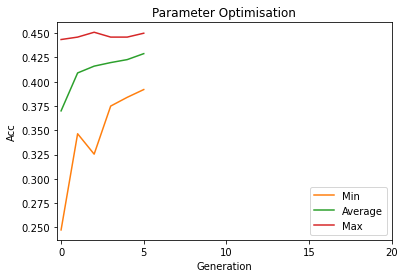

In [ ]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X_transformed[0:10000,0:1500], y[0:10000], stratify=y[0:10000], test_size=0.20)
#ytrue = np.argmax(y_test, axis=1)
#ytrue = ytrue.tolist()

def mutate(individual):
    
    gene = random.randint(0,2) #select which parameter to mutate
    if gene == 0:
        temp_hidden = [(500),(500,500),(500,1000,500)]
        temp_hidden.remove(individual[0])
        individual[0] = random.choice(temp_hidden)
        
    elif gene == 1:
        temp_activation = ['tanh', 'logistic', 'relu']
        temp_activation.remove(individual[1])
        individual[1] = random.choice(temp_activation)
    
    elif gene == 2:
        temp_solver = ['sgd', 'adam', 'lbfgs']
        temp_solver.remove(individual[2])
        individual[2] = random.choice(temp_solver)
        
    return individual,


def evaluate(individual):
    # extract the values of the parameters from the individual chromosome
    hidden_layers = individual[0]
    activation_func = individual[1]
    solver = individual[2]
    
    
    # build the model
    mlp = MLPClassifier(verbose=True, hidden_layer_sizes=hidden_layers, activation=activation_func, solver=solver, max_iter=200)
    mlp.fit(X_train, y_train) 
    
    ypredict = mlp.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, ypredict)
    print(f"accuracy: {accuracy} solver: {solver} hidden_layers: {hidden_layers} activation_func: {activation_func}")
    #roc_auc = metrics.auc(fpr, tpr)
    
    return accuracy,

    


creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # Maximise the fitness function value
creator.create("Individual", list, fitness=creator.FitnessMax)


toolbox = base.Toolbox()

hidden_layer_sizes = [(500),(500,500),(500,1000,500)]
activation = ['tanh', 'logistic', 'relu']
solver = ['sgd', 'adam', 'lbfgs']



N_CYCLES = 1

toolbox.register("attr_hidden", random.choice, hidden_layer_sizes)
toolbox.register("attr_active", random.choice, activation)
toolbox.register("attr_solver", random.choice, solver)


toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_hidden, toolbox.attr_active, toolbox.attr_solver), n=N_CYCLES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate",mutate)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("evaluate", evaluate)

population_size = 15
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 5

pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=crossover_probability, stats = stats, 
                               mutpb = mutation_probability, ngen=number_of_generations, halloffame=hof, 
                               verbose=True) 

best_parameters = hof[0] # save the optimal set of parameters





gen = log.select("gen")
max_ = log.select("max")
avg = log.select("avg")
min_ = log.select("min")

evolution = pd.DataFrame({'Generation': gen,
                         'Max acc': max_,
                          'Average':avg,
                         'Min acc': min_})

plt.title('Parameter Optimisation')
plt.plot(evolution['Generation'], evolution['Min acc'], 'b', color = 'C1',
         label = 'Min')
plt.plot(evolution['Generation'], evolution['Average'], 'b', color = 'C2',
         label = 'Average')
plt.plot(evolution['Generation'], evolution['Max acc'], 'b', color = 'C3',
         label= 'Max')


plt.legend(loc = 'lower right')
plt.ylabel('Acc')
plt.xlabel('Generation')
plt.xticks([0,5,10,15,20])